# Part II: Road Lane Detection Using Hough Transform

In [139]:
import cv2 as cv
from utils import *
import os
import numpy as np

In [140]:
def get_images(path):
    imgs = []
    files = os.listdir(path)
    for file in files:
        imgs.append(read_image(path + file))
    return imgs

In [141]:
# get images from path
path = 'images/lanes/'
images = get_images(path)

Number of images: 3


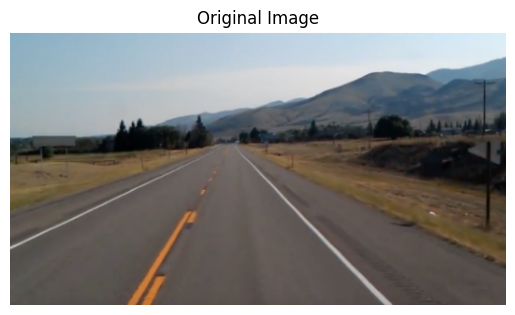

In [201]:
print('Number of images:', len(images))
img = images[0]
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
show_image(img, 'Original Image')

In [202]:
def median_smoothing(img, kernel_size):
    return cv.medianBlur(img, kernel_size)

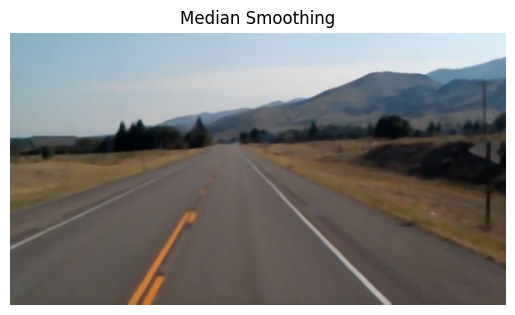

In [203]:
# median smoothing
img = median_smoothing(img, 5)
show_image(img, 'Median Smoothing')

In [204]:
def canny_edge_detection(img, low_threshold, high_threshold):
    return cv.Canny(img, low_threshold, high_threshold)

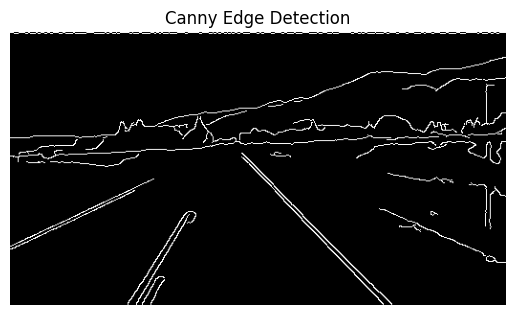

In [205]:
edges = canny_edge_detection(img, 50, 150)
show_image(edges, 'Canny Edge Detection')

In [206]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv.bitwise_and(img, mask)
    return masked_image

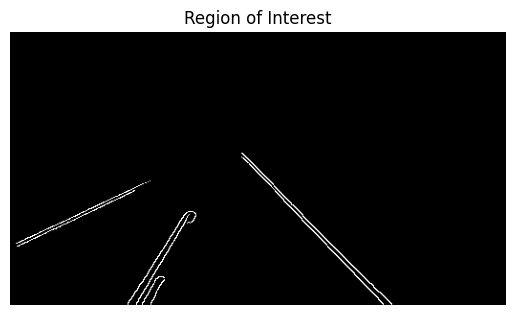

In [207]:
height, width = edges.shape
vertices = np.array([[
        (int(0.1 * width), height),
        (int(0.000 * width), int(0.75 * height)),
        (int(0.46 * width), int(0.42 * height)),
        (int(1 * width), height)
    ]], dtype=np.int32)
    
roi_edges = region_of_interest(edges, vertices)
show_image(roi_edges, 'Region of Interest')

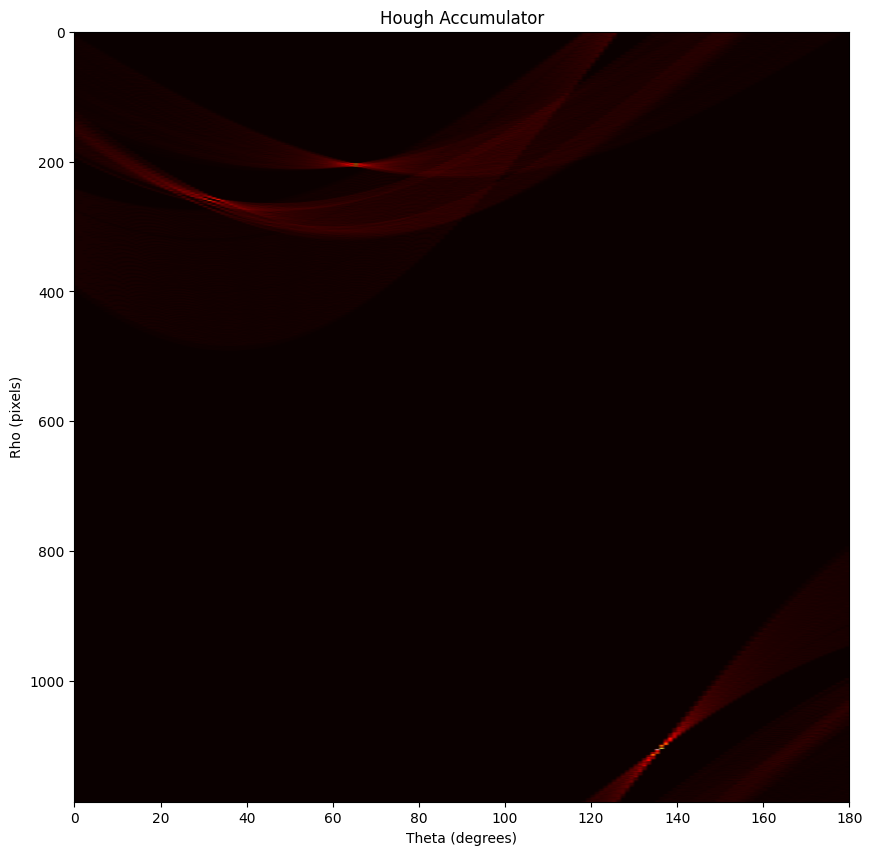

In [258]:
def hough_transform(edge_img, p_bin=1, theta_bin=1):

    height, width = edge_img.shape
    thetas = np.deg2rad(np.arange(0, 180, theta_bin))
    diag_len = int(np.ceil(np.hypot(height, width)))
    ps = np.arange(0, 2 * diag_len + 1, p_bin)
    accumulator = np.zeros((len(ps), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(edge_img)
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx, theta in enumerate(thetas):
            p = int(round(x * np.cos(theta) + y * np.sin(theta)))
            accumulator[p, t_idx] += 1
    return accumulator, thetas, ps



accumulator, thetas, ps = hough_transform(roi_edges, p_bin=1, theta_bin=1)
plt.figure(figsize=(10, 10))
plt.title("Hough Accumulator")
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.imshow(accumulator, cmap="hot", aspect='auto',
            extent=[0, 180, ps[-1], ps[0]])
plt.show()




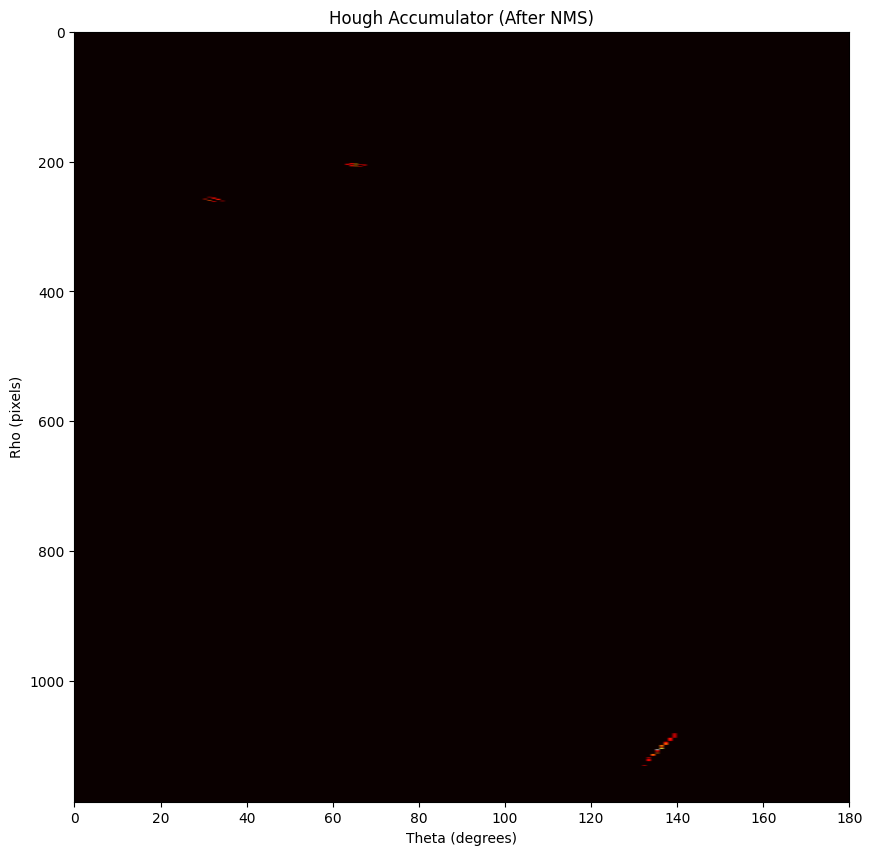

In [262]:

def non_maximum_suppression(acc, neighborhood_size=3, threshold=10):
    suppressed = np.copy(acc)
    half_size = neighborhood_size // 2
    for i in range(half_size, acc.shape[0] - half_size):
        for j in range(half_size, acc.shape[1] - half_size):
            window = acc[i - half_size : i + half_size + 1,
                         j - half_size : j + half_size + 1]
            if acc[i, j] != np.max(window) or acc[i, j] < threshold:
                suppressed[i, j] = 0
    return suppressed

acc_nms = non_maximum_suppression(accumulator, neighborhood_size=1, threshold=50)

plt.figure(figsize=(10, 10))
plt.title("Hough Accumulator (After NMS)")
plt.xlabel("Theta (degrees)")
plt.ylabel("Rho (pixels)")
plt.imshow(acc_nms, cmap="hot", aspect='auto',
            extent=[0, 180, ps[-1], ps[0]])
plt.show()

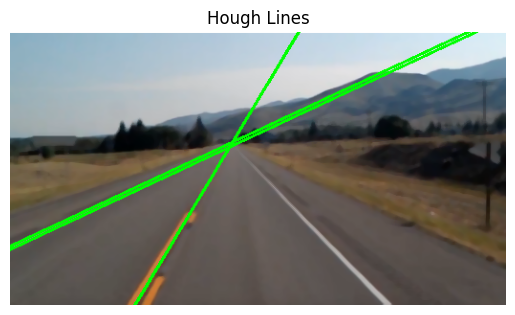

In [265]:
def hough_peaks(hough_acc, num_peaks, threshold=50, nhood_size=3):
    peaks = []
    acc = hough_acc.copy()
    for i in range(num_peaks):
        r, theta = np.unravel_index(acc.argmax(), acc.shape)
        if acc[r, theta] < threshold:
            break
        peaks.append((r, theta))
        r1 = max(0, r - nhood_size)
        r2 = min(acc.shape[0], r + nhood_size + 1)
        t1 = max(0, theta - nhood_size)
        t2 = min(acc.shape[1], theta + nhood_size + 1)
        acc[r1:r2, t1:t2] = 0
    return peaks


peaks = hough_peaks(accumulator, num_peaks=10, threshold=50, nhood_size=1)
def draw_hough_lines(img, lines):
    img = np.copy(img)
    for r, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * r
        y0 = b * r
        x1 = int(x0 + 500 * (-b))
        y1 = int(y0 + 500 * (a))
        x2 = int(x0 - 500 * (-b))
        y2 = int(y0 - 500 * (a))
        cv.line(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

lines = [(p, np.deg2rad(t)) for p, t in peaks]
hough_lines = draw_hough_lines(img, lines)
show_image(hough_lines, 'Hough Lines')

